In [1]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

from pettingzoo.classic import tictactoe_v3
import numpy as np
import copy
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.dqn_agent import DQNAgent
from source.agents.advantage_actor_critic_agent import A2CAgent
from source.agents.ppo_agent import PPOAgent
from source.agents.random_agent import RandomAgent
from source.utils import utils
from tqdm import tqdm
import torch
import random
from typing import Dict, Optional, Tuple
from collections import defaultdict
from source.agents.agent import Agent
from pettingzoo.utils.env import AECEnv

/Users/tonywy/micromamba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device: cpu
dqn_agent test passed!
using device: cpu
a2c_agent test passed!
using device: cpu
ppo_agent passed!


using device: cpu
using device: cpu
using device: cpu


100%|██████████| 1000/1000 [00:03<00:00, 265.09it/s]


step: 0,  epsilon:None, average_return: 0.407, average_epi_len: 5.007, p1 win: 657, lose: 250, draw: 93, policy_loss: -0.07303427952900529, value_loss: 0.5518789785727859


100%|██████████| 1000/1000 [00:03<00:00, 281.79it/s]


step: 1,  epsilon:None, average_return: 0.644, average_epi_len: 4.63, p1 win: 798, lose: 154, draw: 48, policy_loss: -0.049646874536876565, value_loss: 0.379159013279248


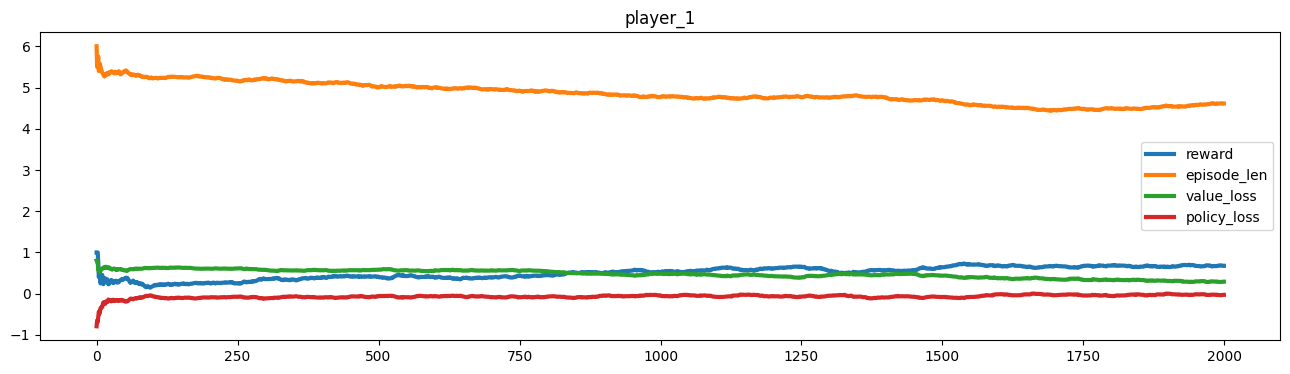

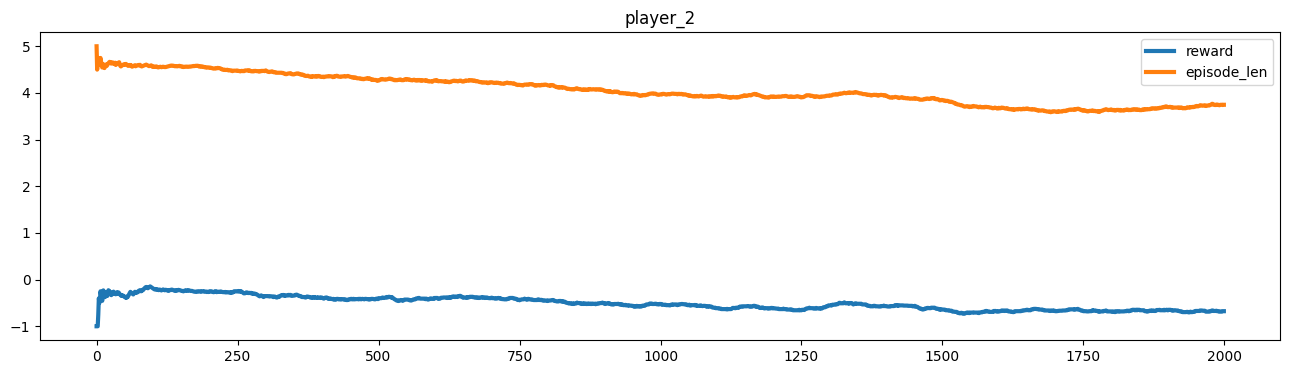

In [17]:
# Policy Eval
# Params
num_epoch = 2
num_episode = 1000
random_seed = 101

# Initialize
# set random seeds
rng = np.random.default_rng(random_seed)
#random.seed(random_seed)
#torch.manual_seed(random_seed)
# epsilon decay

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
#env = gym.make(
#    "LunarLander-v2",
#    render_mode='rgb_array'
#)
#env = gym.make("CarRacing-v2", render_mode='rgb_array', continuous=False)
#env = gym.make("CartPole-v1", render_mode='rgb_array')

env = tictactoe_v3.env()
env.np_random = rng

# Create Agent
## Best performance (dqn, random): 0 loss in 1000, eps_decay=1e7
## Best performance (dqn, dqn): 1000 draw in 1000, eps_decay=1e8
dqn_agent = DQNAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.7,
    epsilon=0.9, # use epsilon_schedule
    learning_rate=1e-3,
    learning=True,
    batch_size = 32,
    tau = 0.005,
    eps_decay=1e8, #1e7 for (dqn, random), 1e8 for (dqn, dqn)
    net_params={'width':16, 'n_hidden':1},
    update_freq=1
)
## Best performance (a2c, random): ~50 loss in 1000, discount=0.5, width=256
a2c_agent = A2CAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    policy_lr=1e-3,
    value_lr=1e-3,
    net_params={'width':256, 'n_hidden':1}, #128 perform best with temp = 1
    tempreture=1
)
ppo_agent = PPOAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    policy_lr=1e-3,
    value_lr=1e-3,
    net_params={'width':128, 'n_hidden':1},
    exp_average_discount=1.0,
    clip_ratio=0.1,
    num_updates=1,
)

random_agent = RandomAgent(    
    state_space=env.observation_space('player_2')['observation'],
    action_space=env.action_space('player_2'),
    discount_rate=None,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    learning=False
)

agent_dict = {'player_1': a2c_agent, 'player_2':random_agent}
log_history = []
# Start Learning
for i in range(num_epoch):
    p1_reward, episode_len, policy_loss, value_loss = [], [], [], []
    for _ in tqdm(range(num_episode)):
        logs = utils.play_multiagent_episode(agent_dict, env, shuffle=False)#,epsilon=epsilon_schedule[i])
        p1_reward.append(logs['player_1']['reward'])
        episode_len.append(logs['player_1']['episode_len'])
        policy_loss.append(logs['player_1']['policy_loss'])
        value_loss.append(logs['player_1']['value_loss'])
        log_history.append(logs)
    print(
        f"step: {i},  epsilon:{agent_dict['player_1']._epsilon}, average_return: {np.mean(p1_reward)}, average_epi_len: {np.mean(episode_len)}, p1 win: {p1_reward.count(1)}, lose: {p1_reward.count(-1)}, draw: {p1_reward.count(0)}, policy_loss: {np.mean(policy_loss)}, value_loss: {np.mean(value_loss)}")

utils.plot_logs(log_history)
#utils.plot_history(eps_history, smoothing=False)

In [ ]:
env = tictactoe_v3.env(render_mode='human')
utils.play_multiagent_episode({'player_1': agent_dict['player_1'], 'player_2':agent_dict['player_2']}, env)
#html=utils.render_mp4(video_path)
#HTML(html)


     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  O  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  O  |  -  
_____|_____|_____
     |     |     
  -  |  X  |  -  
     |     |     
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  O  |  -  
_____|_____|_____
     |     |     
  O  |  X  |  -  
     |     |     
     |     |     
  -  |  X  |  X  
_____|_____|_____
     |     |     
  -  |  O  |  -  
_____|_____|_____
     |     |     
  O  |  X  |  -  
     |     |     
     |     |     
  -  |  X  |  X  
_____|_____|_____
     |     |     
  -  |  O  |  O  
_____|_____|_____
     |     |     
  O  |  X  |  -  
     |     |     
     |     |     
  X  |  X 

(defaultdict(float, {'player_1': 1.0, 'player_2': -1.0}),
 defaultdict(int, {'player_1': 5, 'player_2': 4}),
 defaultdict(float, {'player_1': 0.05213126540184021}),
 defaultdict(float, {'player_1': -0.13190419971942902}))